# Grant-Recipient-Classifier-Pipeline

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from google.colab import files
from scipy.stats import ks_2samp
from matplotlib import pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

## Data Uploading

**Note:-** *Only sample original applicant data will be used here. The actual original could not be availed for privacy reasons.*

In [2]:
# Load data from CSV
data = pd.read_csv('/content/Sample Original Applicant Data.csv')

# View the first few rows of the dataset
data.head()

,Timestamp,Email address,"Applicants submitting their applications warrant that all information that is submitted, is true and accurate and will keep ALU’s Financial Aid team informed without delay of any change to such information and comply with the present terms and conditions. Submitting false information will result in the applicant’s disqualification from the application process and may, at ALU’s request, require the selected student to reimburse any grants that may have already been awarded to them under this scheme. The awarded grants can only be used by the selected student applicant, for alleviating their financial hardship whilst studying at ALU. I, the undersigned applicant, hereby warrant that I am duly authorised to provide all of the personal data in this form, pertaining to third parties, such as my guardians.\n",First Name (as per passport),Middle Name,Last Name (as per passport),Nationality,Gender,Intake (Month),Intake (Year),...,"In light of your new financial circumstances, how much can your family contribute annually in USD, towards your education at ALU?",How many people are in your household including yourself?,How many people in your household contribute to the household monthly income?,How many people in your household are dependents (A dependent is a person who relies on another as a primary source of income)?,How do you finance your education at ALU?,"In light of your new financial circumstances, how much can your financier(s) contribute annually in USD, towards your education at ALU?",How do you intend to continue financing your education at ALU in light of your new situation?,"In no more than 250 words, please provide any useful information about your unique financial circumstances, that is, why you are unable to afford your education at ALU.",Kindly upload any supporting document(s) for your essay or impactful community project.,"DATA PROTECTION: \n\nWe are committed to safeguarding your personal data and ensuring its confidentiality. For information on how we process your personal data, please consult our Privacy Policy here. By submitting this form, you, the undersigned, agree for us to process your personal data as per our said Privacy Policy.\n\n"
0,4/23/2024 10:36:44,xxx,I accept the application terms and conditions,xxx,NaN,xxx,Rwanda,Male,May,2023,...,Under 500,8 and Over,1,8 and Over,"Self, Family (Parents/Guardians/Siblings)",Under USD. 500,"Self, Scholarships, Sponsorships, Grants, etc.",Despite my passion for software engineering an...,NaN,Agree
1,4/23/2024 14:34:09,xxx,I accept the application terms and conditions,xxx,NaN,xxx,Rwanda,Male,May,2023,...,Under 500,Under 8,1,Under 8,"Family (Parents/Guardians/Siblings), Scholarsh...",Under USD. 500,"Self, Parent/Guardian, Scholarships, Sponsorsh...",I am writing to request financial assistance t...,NaN,Agree
2,4/23/2024 18:26:57,xxx,I accept the application terms and conditions,xxx,NaN,xxx,Rwanda,Female,January,2023,...,Under 500,8 and Over,1,Under 8,"Scholarships, Sponsorships, Grants, etc.",Under USD. 500,"Scholarships, Sponsorships, Grants, etc.",My family started out good but there have been...,NaN,Agree
3,4/23/2024 18:54:12,xxx,I accept the application terms and conditions,xxx,xxx,xxx,Rwanda,Female,May,2023,...,Under 500,8 and Over,1,8 and Over,Family (Parents/Guardians/Siblings),Between USD. 500 and USD. 1500,"Self, Parent/Guardian",I'm unable to afford my education at ALU becau...,NaN,Agree


In [3]:
# Load data from CSV
clean_data = pd.read_csv('/content/Cleaned Applicant Data - T, T & V.csv')

# View the first few rows of the dataset
clean_data.head()

,Academic Standing,Disciplinary Standing,Fnancial Standing,Fee balance (USD),ALU Grant Status,Previous Alusive Grant Status,Total Monthly Income,Students in Household,Household Size,Household Supporters,Household Dependants,ALU Grant Amount,Grant Requested,Amount Affordable,Grant Classifier
0,1,1,0,500.0,0,0,1000,5,10,1,8,0,1500,500,1
1,0,0,0,1280.0,1,0,1000,1,4,2,2,1500,1000,500,0
2,1,1,0,1500.0,0,0,1250,3,8,1,4,0,1000,1000,1
3,1,1,0,1500.0,0,0,1500,3,10,1,8,0,1500,1000,1
4,1,1,0,500.0,1,0,1000,2,2,1,2,2000,1000,500,1


## Data Preprocessing

In [4]:
# Load the data
file_path = '/content/Sample Original Applicant Data.csv'
data = pd.read_csv(file_path)

# Identify columns that won't be useful for the objectives of our analysis to drop
columns_to_drop = [0,1,2,3,4,5,6,7,8,9,10,14,16,17,24,25,27,31,33,34,35,36]

# Drop the specified columns
data_dropped = data.drop(data.columns[columns_to_drop], axis=1)

# Create a DataFrame with column indices and names
columns_df = pd.DataFrame({
    'Index': range(len(data_dropped.columns)),
    'Column Name': data_dropped.columns
})

# Display the needed columns
print(columns_df)

    Index                                        Column Name
0       0                 Are you in good academic standing.
1       1             Are you in good disciplinary standing.
2       2                Are you in good financial standing?
3       3  What amount is the outstanding tuitions fee ba...
4       4           Do you receive a grant from ALU already?
5       5                   How much is that grant from ALU?
6       6  Have you received a previous Alusive grant (Co...
7       7  How much are you looking for from this grant a...
8       8  What is the number of people currently enrolle...
9       9  What is the total household monthly income in ...
10     10  What is the total monthly amount of money in U...
11     11  How many people are in your household includin...
12     12  How many people in your household contribute t...
13     13  How many people in your household are dependen...
14     14  In light of your new financial circumstances, ...


In [5]:
# Mapping of old column names to new column names
rename_mapping = {
    data_dropped.columns[0]: 'Academic Standing',
    data_dropped.columns[1]: 'Disciplinary Standing',
    data_dropped.columns[2]: 'Financial Standing',
    data_dropped.columns[3]: 'Fee balance (USD)',
    data_dropped.columns[4]: 'ALU Grant Status',
    data_dropped.columns[5]: 'ALU Grant Amount',
    data_dropped.columns[6]: 'Previous Alusive Grant Status',
    data_dropped.columns[7]: 'Grant Requested',
    data_dropped.columns[8]: 'Students in Household',
    data_dropped.columns[9]: 'Total Monthly Income',
    data_dropped.columns[10]: 'Total Monthly Income (Assets)',
    data_dropped.columns[11]: 'Household Size',
    data_dropped.columns[12]: 'Household Supporters',
    data_dropped.columns[13]: 'Household Dependants',
    data_dropped.columns[14]: 'Amount Affordable',
}

# Rename the columns
data_renamed = data_dropped.rename(columns=rename_mapping)

# Display the DataFrame with renamed columns
print(data_renamed.head())

  Academic Standing Disciplinary Standing Financial Standing  \
0               Yes                   Yes                Yes   
1               Yes                   Yes                Yes   
2               Yes                   Yes                 No   
3               Yes                   Yes                Yes   

   Fee balance (USD) ALU Grant Status ALU Grant Amount  \
0               2000              Yes        USD. 2000   
1                500              Yes        USD. 1500   
2               1500              Yes        USD. 1500   
3               1000              Yes        USD. 1000   

  Previous Alusive Grant Status                 Grant Requested  \
0                            No                       Over 1500   
1                            No  Between USD. 500 and USD. 1500   
2                            No  Between USD. 500 and USD. 1500   
3                            No  Between USD. 500 and USD. 1500   

  Students in Household Total Monthly Income Total M

In [6]:
# Binary encode Yes/No values
# Replace 'yes' with 1 and 'no' with 0
data_renamed.replace({'Yes': 1, 'No': 0}, inplace=True)

# Display the DataFrame
print(data_renamed)

   Academic Standing  Disciplinary Standing  Financial Standing  \
0                  1                      1                   1   
1                  1                      1                   1   
2                  1                      1                   0   
3                  1                      1                   1   

   Fee balance (USD)  ALU Grant Status ALU Grant Amount  \
0               2000                 1        USD. 2000   
1                500                 1        USD. 1500   
2               1500                 1        USD. 1500   
3               1000                 1        USD. 1000   

   Previous Alusive Grant Status                 Grant Requested  \
0                              0                       Over 1500   
1                              0  Between USD. 500 and USD. 1500   
2                              0  Between USD. 500 and USD. 1500   
3                              0  Between USD. 500 and USD. 1500   

  Students in Household Tot

In [7]:
# Encode the values
# Convert the column to strings
data_renamed['ALU Grant Amount'] = data_renamed['ALU Grant Amount'].astype(str)

# Remove 'USD. ' prefix and any spaces, then convert to integer
data_renamed['ALU Grant Amount'] = data_renamed['ALU Grant Amount'].str.replace('USD. ', '', regex=False)

# If you need the value to be an integer:
data_renamed['ALU Grant Amount'] = data_renamed['ALU Grant Amount'].astype(int)

# Display the DataFrame
print(data_renamed)

   Academic Standing  Disciplinary Standing  Financial Standing  \
0                  1                      1                   1   
1                  1                      1                   1   
2                  1                      1                   0   
3                  1                      1                   1   

   Fee balance (USD)  ALU Grant Status  ALU Grant Amount  \
0               2000                 1              2000   
1                500                 1              1500   
2               1500                 1              1500   
3               1000                 1              1000   

   Previous Alusive Grant Status                 Grant Requested  \
0                              0                       Over 1500   
1                              0  Between USD. 500 and USD. 1500   
2                              0  Between USD. 500 and USD. 1500   
3                              0  Between USD. 500 and USD. 1500   

  Students in Househol

In [8]:
# Mapping the values
mapping = {
    "Under USD. 500": 500,
    "Under 500": 500,
    "Between 500 - 1000": 750,
    "Between USD. 500 and USD. 1500": 1000,
    "Over 1500" : 2000,
}

# Replace the values in the DataFrame
data_renamed["Grant Requested"] = data_renamed["Grant Requested"].replace(mapping)
data_renamed["Total Monthly Income"] = data_renamed["Total Monthly Income"].replace(mapping)
data_renamed["Total Monthly Income (Assets)"] = data_renamed["Total Monthly Income (Assets)"].replace(mapping)
data_renamed["Amount Affordable"] = data_renamed["Amount Affordable"].replace(mapping)

# Display the updated DataFrame
print(data_renamed)

   Academic Standing  Disciplinary Standing  Financial Standing  \
0                  1                      1                   1   
1                  1                      1                   1   
2                  1                      1                   0   
3                  1                      1                   1   

   Fee balance (USD)  ALU Grant Status  ALU Grant Amount  \
0               2000                 1              2000   
1                500                 1              1500   
2               1500                 1              1500   
3               1000                 1              1000   

   Previous Alusive Grant Status  Grant Requested Students in Household  \
0                              0             2000                     1   
1                              0             1000                     3   
2                              0             1000                     1   
3                              0             1000              

In [9]:
# Mapping the values
mapping = {
    "Over 4": 4,
    "Under 8": 8,
    "8 and Over": 10,
}

# Replace the values in the DataFrame
data_renamed["Students in Household"] = data_renamed["Students in Household"].replace(mapping)
data_renamed["Household Size"] = data_renamed["Household Size"].replace(mapping)
data_renamed["Household Dependants"] = data_renamed["Household Dependants"].replace(mapping)

# Display the updated DataFrame
print(data_renamed)

   Academic Standing  Disciplinary Standing  Financial Standing  \
0                  1                      1                   1   
1                  1                      1                   1   
2                  1                      1                   0   
3                  1                      1                   1   

   Fee balance (USD)  ALU Grant Status  ALU Grant Amount  \
0               2000                 1              2000   
1                500                 1              1500   
2               1500                 1              1500   
3               1000                 1              1000   

   Previous Alusive Grant Status  Grant Requested Students in Household  \
0                              0             2000                     1   
1                              0             1000                     3   
2                              0             1000                     1   
3                              0             1000              

In [10]:
# Feature Engineering by Aggregation
# Create a new column that is the sum of two existing columns
data_renamed['Total Monthly Income'] = data_renamed['Total Monthly Income'] + data_renamed['Total Monthly Income (Assets)']

# Drop the column and update the DataFrame
data_renamed = data_renamed.drop('Total Monthly Income (Assets)', axis=1)

# Convert the column to float
data_renamed['Fee balance (USD)'] = data_renamed['Fee balance (USD)'].astype(float)

# Display the DataFrame
print(data_renamed.head())

   Academic Standing  Disciplinary Standing  Financial Standing  \
0                  1                      1                   1   
1                  1                      1                   1   
2                  1                      1                   0   
3                  1                      1                   1   

   Fee balance (USD)  ALU Grant Status  ALU Grant Amount  \
0             2000.0                 1              2000   
1              500.0                 1              1500   
2             1500.0                 1              1500   
3             1000.0                 1              1000   

   Previous Alusive Grant Status  Grant Requested Students in Household  \
0                              0             2000                     1   
1                              0             1000                     3   
2                              0             1000                     1   
3                              0             1000              

## Training

In [11]:
# Summary statistics of the dataset
clean_data.describe()

,Academic Standing,Disciplinary Standing,Fnancial Standing,Fee balance (USD),ALU Grant Status,Previous Alusive Grant Status,Total Monthly Income,Students in Household,Household Size,Household Supporters,Household Dependants,ALU Grant Amount,Grant Requested,Amount Affordable,Grant Classifier
count,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000
mean,0.981651,0.995413,0.279817,1045.418578,0.862385,0.091743,1221.330275,2.834862,7.385321,1.371560,5.853211,1337.155963,1089.449541,683.486239,0.637615
std,0.134517,0.067729,0.449942,805.010744,0.345288,0.289327,509.170801,1.562898,2.015645,0.571616,2.331217,625.749456,275.795740,315.940192,0.481796
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,1.000000,2.000000,1.000000,2.000000,0.000000,500.000000,500.000000,0.000000
25%,1.000000,1.000000,0.000000,500.000000,1.000000,0.000000,1000.000000,1.000000,6.000000,1.000000,4.000000,1000.000000,1000.000000,500.000000,0.000000
50%,1.000000,1.000000,0.000000,1000.000000,1.000000,0.000000,1000.000000,3.000000,8.000000,1.000000,6.000000,1500.000000,1000.000000,500.000000,1.000000
75%,1.000000,1.000000,1.000000,1500.000000,1.000000,0.000000,1250.000000,5.000000,8.000000,2.000000,8.000000,2000.000000,1500.000000,1000.000000,1.000000
max,1.000000,1.000000,1.000000,3000.000000,1.000000,1.000000,5000.000000,5.000000,10.000000,4.000000,10.000000,2000.000000,1500.000000,2000.000000,1.000000


In [12]:
# Check for missing values in the dataset
clean_data.isnull().sum()

,0
Academic Standing,0
Disciplinary Standing,0
Fnancial Standing,0
Fee balance (USD),0
ALU Grant Status,0
Previous Alusive Grant Status,0
Total Monthly Income,0
Students in Household,0
Household Size,0
Household Supporters,0


In [13]:
# Count grant classes
clean_data['Grant Classifier'].value_counts()

,count
Grant Classifier,
1,139
0,79


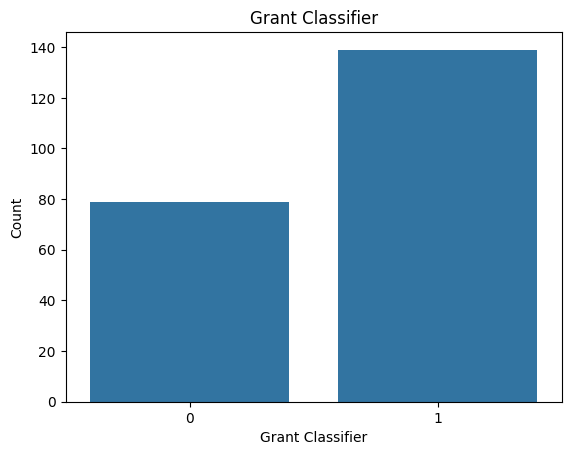

In [14]:
# Visualize the grant classes
sns.countplot(x='Grant Classifier', data=clean_data)
plt.title('Grant Classifier')
plt.xlabel('Grant Classifier')
plt.ylabel('Count')
plt.show()

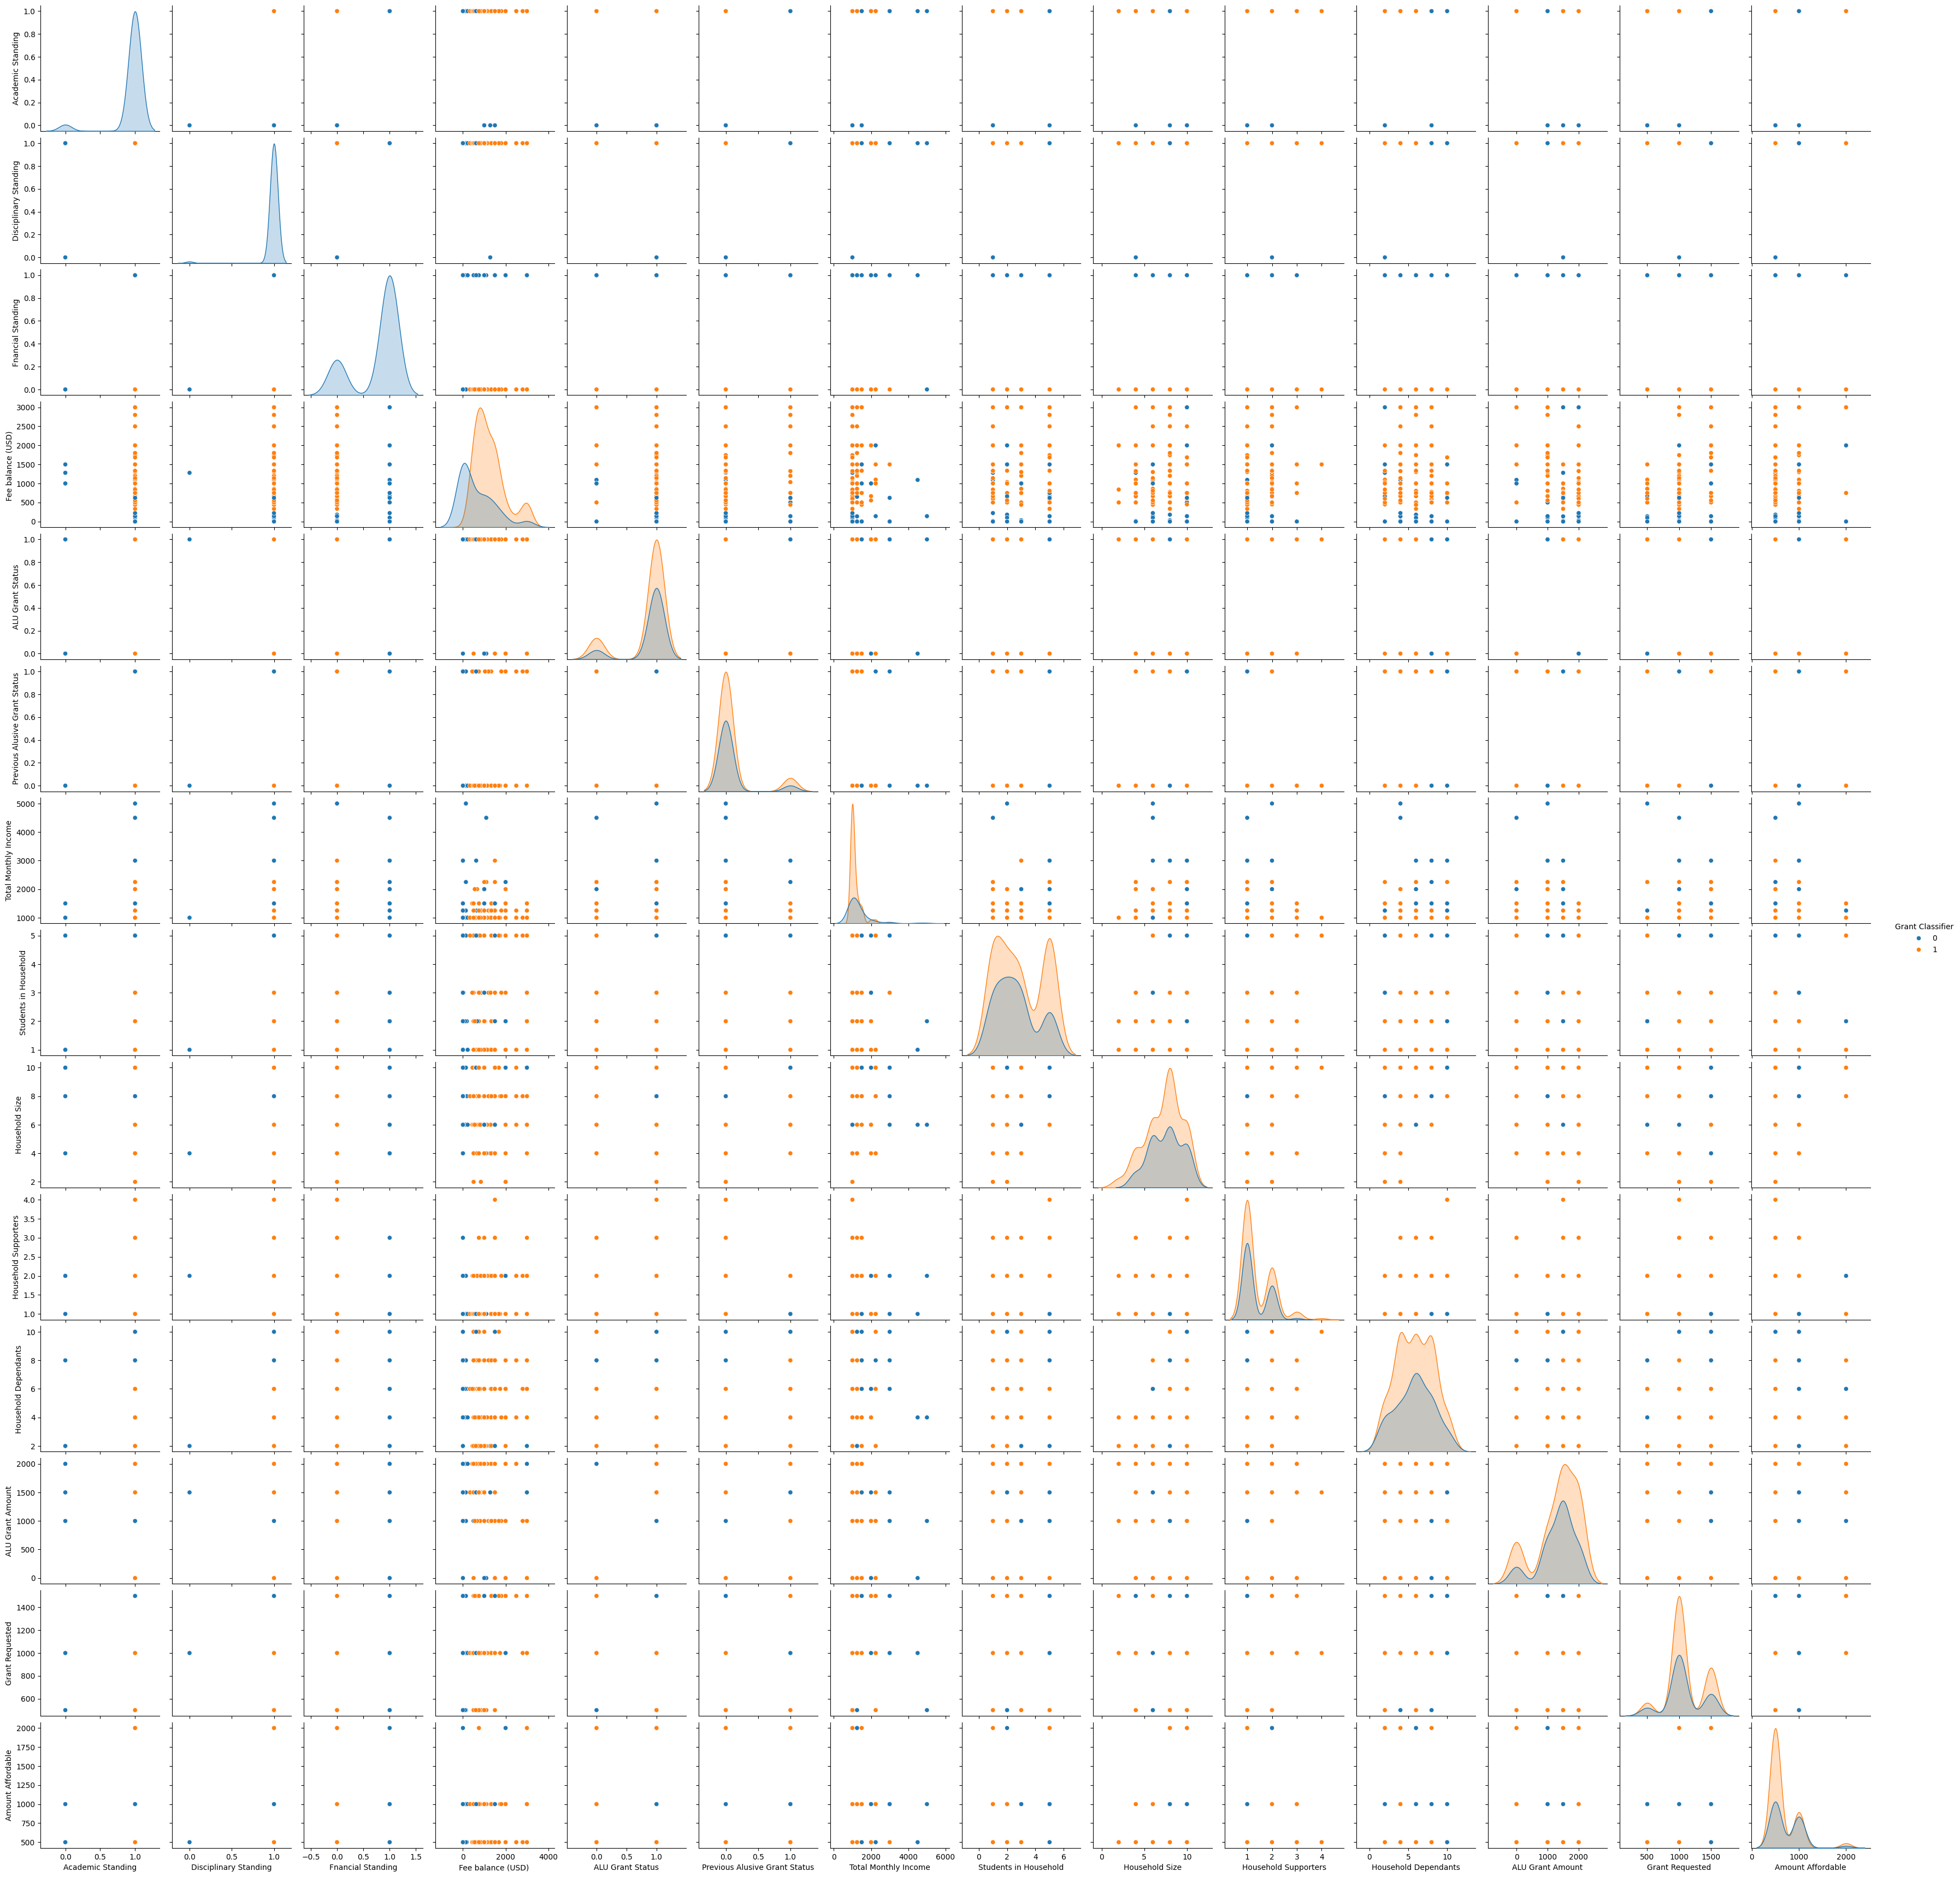

In [15]:
# General overview of data distribution
sns.pairplot(clean_data.iloc[:,:], hue = "Grant Classifier");
plt.show()

In [16]:
# Encoded distribution of Data
qualification_map = {0: 0, 1: 1}

clean_data['Grant Classifier'] = clean_data['Grant Classifier'].map(qualification_map)

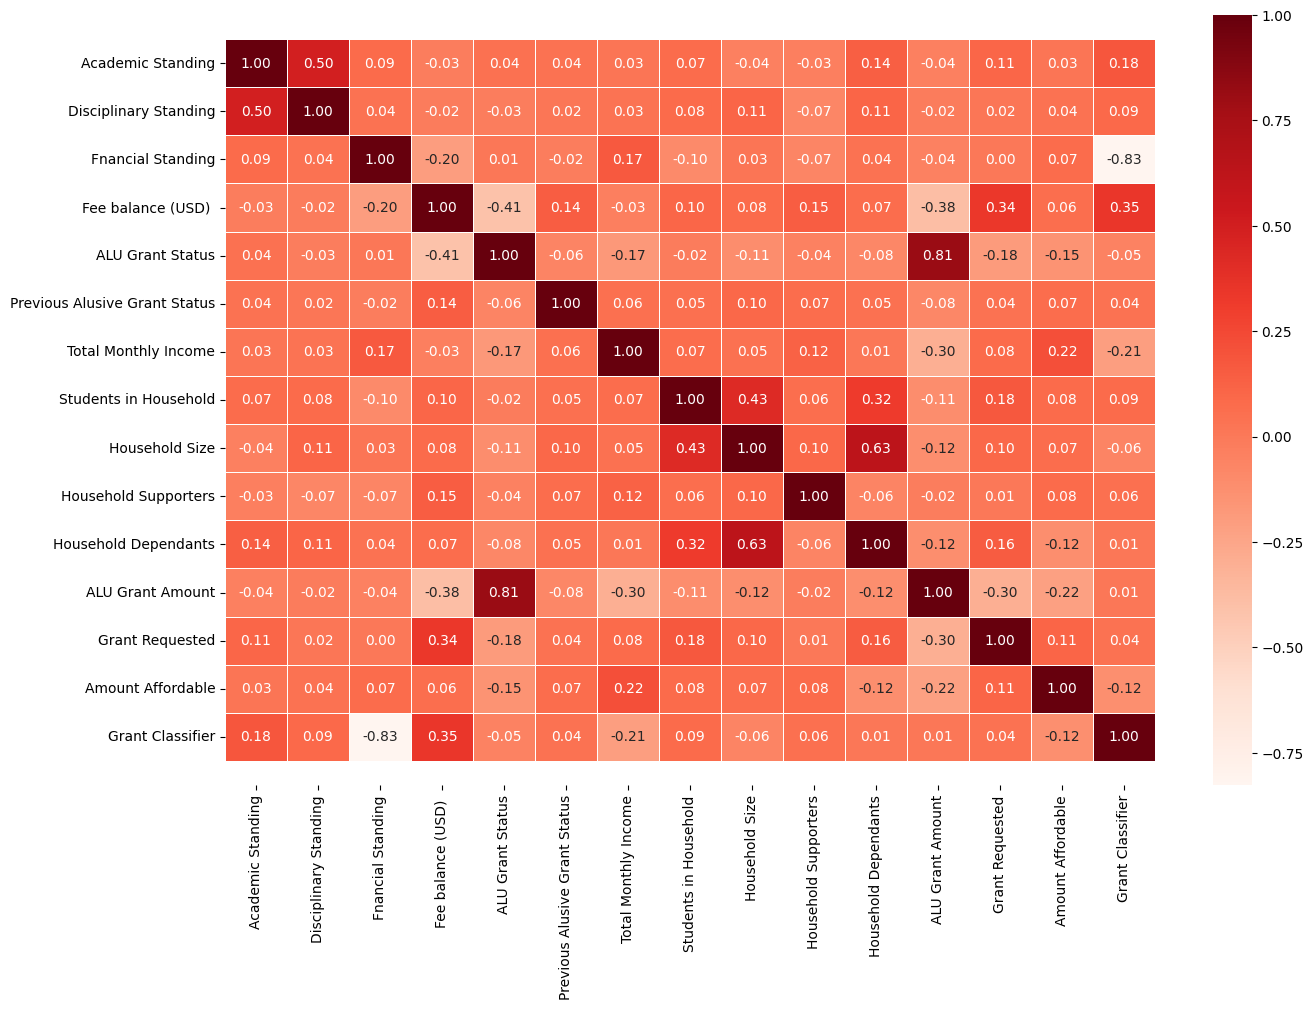

In [17]:
# Plot a correlation heatmap
corr_matrix = clean_data.corr()
fig, ax = plt.subplots(figsize = (15, 10))
ax = sns.heatmap(corr_matrix,
                 annot = True,
                 linewidths = 0.5,
                 fmt = ".2f",
                 cmap = "Reds");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

In [18]:
# Features and labels of the model
X = clean_data.drop(['Grant Classifier'], axis = 1)
y = clean_data['Grant Classifier']

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

# Fit the scaler on the training features and transform both train and test features
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

# Convert back to DataFrame for easier saving and handling
X_train_standardized = pd.DataFrame(X_train_standardized, columns=X_train.columns)
X_test_standardized = pd.DataFrame(X_test_standardized, columns=X_test.columns)

In [20]:
# Create the directory if it does not exist
os.makedirs('/data/train', exist_ok=True)
os.makedirs('/data/test', exist_ok=True)

# Save standardized train data
X_train_standardized.to_csv('/data/train/X_train_standardized.csv', index=False)
y_train.to_csv('/data/train/y_train.csv', index=False)

# Save standardized test data
X_test_standardized.to_csv('/data/test/X_test_standardized.csv', index=False)
y_test.to_csv('/data/test/y_test.csv', index=False)



In [21]:
# Download the train files
files.download('/data/train/X_train_standardized.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# Download the train files
files.download('/data/train/y_train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
# Download the test files
files.download('/data/test/X_test_standardized.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
# Download the test files
files.download('/data/test/y_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
X_train.shape

(174, 14)

In [26]:
X_train_standardized.shape

(174, 14)

In [27]:
y_train.shape

(174,)

In [28]:
# Define the model
model = models.Sequential()

# Input layer (you may need to adjust the input shape according to your dataset)
model.add(layers.InputLayer(input_shape=(14,)))

# First hidden layer with L2 regularization, batch normalization, and dropout
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# Second hidden layer with L2 regularization, batch normalization, and dropout
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# Third hidden layer with L2 regularization, batch normalization, and dropout
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# Output layer (adjust the units and activation based on your task, e.g., softmax for classification)
model.add(layers.Dense(1, activation='sigmoid'))  # For binary classification

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,113 (39.50 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [29]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # For multi-class classification; adjust as needed
              metrics=['accuracy'])

In [30]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss',  # Metric to monitor (e.g., 'val_loss', 'val_accuracy')
                               patience=5,         # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True)  # Restores model weights from the epoch with the best value of the monitored metric

In [31]:
# Define a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',  # Metric to monitor
                                 factor=0.2,          # Factor by which the learning rate will be reduced
                                 patience=3,          # Number of epochs with no improvement after which learning rate will be reduced
                                 min_lr=1e-6)         # Minimum learning rate

In [32]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


1/5 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.4375 - loss: 0.1481

/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.3995 - loss: 0.1478 - val_accuracy: 0.5714 - val_loss: 0.1466 - learning_rate: 0.0010
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4377 - loss: 0.1463 - val_accuracy: 0.5714 - val_loss: 0.1453 - learning_rate: 0.0010
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4632 - loss: 0.1450 - val_accuracy: 0.5714 - val_loss: 0.1440 - learning_rate: 0.0010
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4393 - loss: 0.1438 - val_accuracy: 0.5714 - val_loss: 0.1429 - learning_rate: 0.0010
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4923 - loss: 0.1427 - val_accuracy: 0.5714 - val_loss: 0.1418 - learning_rate: 0.0010
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4569 - loss: 0.1416 - val_accuracy: 0.5714 - val_loss: 0.1408 - learning_rate: 0.0010
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5088 - loss: 0.1406 - val_accuracy: 0.6571 - va

In [33]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6629 - loss: 0.1264 
Test Loss: 0.12639448046684265
Test Accuracy: 0.6818181872367859


In [34]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred = (y_pred > 0.5).astype(int)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


In [35]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

Precision: 0.8076923076923077
Recall: 0.7
F1-Score: 0.75
ROC AUC Score: 0.6714285714285714


Confusion Matrix:
[[ 9  5]
 [ 9 21]]


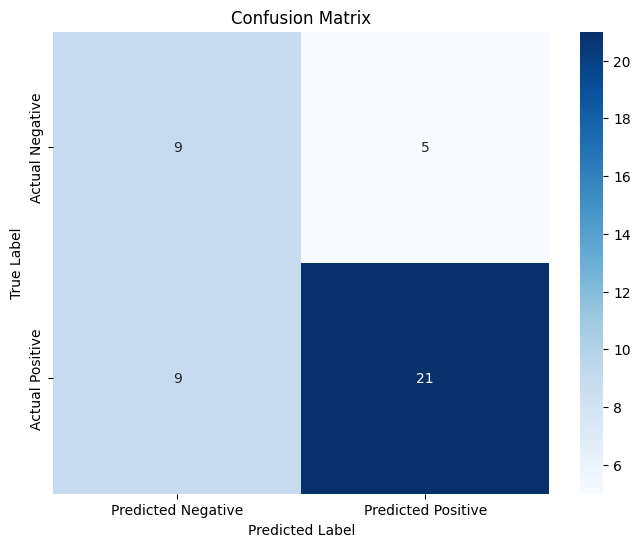

In [36]:
# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optional: Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

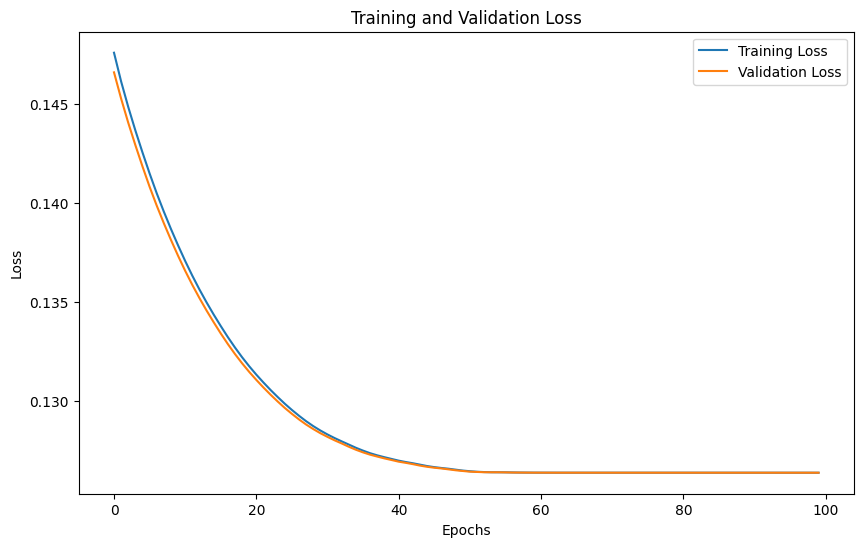

In [37]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

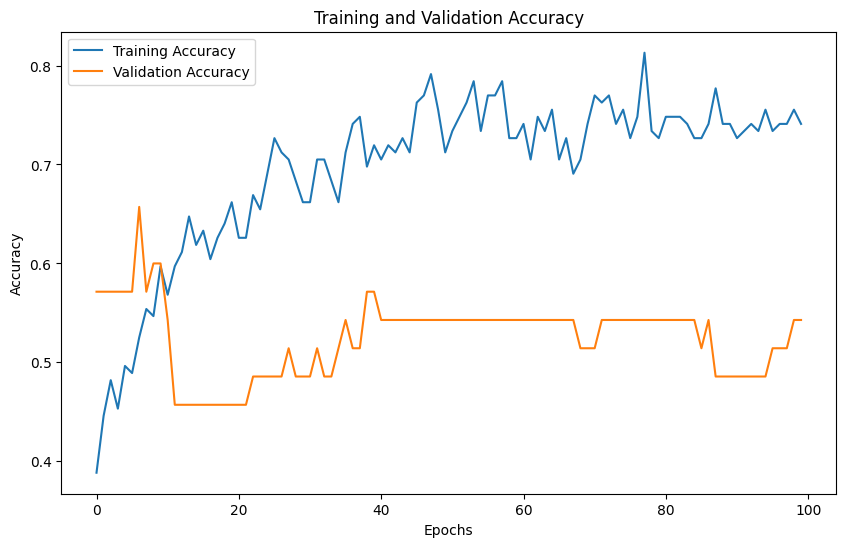

In [38]:
# Plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [39]:
# Create the directory if it does not exist
os.makedirs('./model', exist_ok=True)

# Save the model in the pickle file in the Saved Models folder
pickle.dump(model, open('./model/grant_classifier.pkl', 'wb'))

# Download the model file to your local machine
from google.colab import files
files.download('./model/grant_classifier.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Retraining

In [40]:
# Function to monitor data changes
def has_data_changed(old_data, new_data, threshold=0.05):
    # Perform the Kolmogorov-Smirnov test on each feature
    for column in old_data.columns:
        stat, p_value = ks_2samp(old_data[column], new_data[column])
        if p_value < threshold:
            print(f"Data has changed significantly in column: {column}")
            return True
    return False

In [41]:
# Function to retrain model
def retrain_model(X_train, y_train):
    print("Retraining the model...")
    history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping, lr_scheduler])
    print("Model retrained successfully.")
    return model

# Load old and new datasets
old_data = pd.read_csv('/content/Cleaned Applicant Data - T, T & V.csv')
new_data = pd.read_csv('/content/Cleaned Applicant Data - T, T & V.csv')

# Monitor for data changes
if has_data_changed(old_data, new_data):
    # Prepare data for retraining
    X_train = new_data.drop('target', axis=1)
    y_train = new_data['target']

    # Trigger the retraining process
    retrained_model = retrain_model(X_train, y_train)
else:
    print("No significant data changes detected. Retraining not required.")

No significant data changes detected. Retraining not required.


## Post-retraining Evaluation

In [42]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6629 - loss: 0.1264
Test Loss: 0.12639448046684265
Test Accuracy: 0.6818181872367859
